In [36]:
import pandas as pd
import numpy as np

In [37]:
merged_df = pd.read_csv('merged_df.csv')
merged_df.head()

,ID,Gender,Car,Property,Children,Income,Income status,Education,Marital,Housing,...,Job,Family,0,1,2,3,4,5,C,X
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,NaN,2,1,1,0,0,0,0,13,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,NaN,2,1,1,0,0,0,0,12,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,Security staff,2,7,0,0,0,0,0,7,16
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,Sales staff,1,2,0,0,0,0,0,0,3
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,Sales staff,1,0,0,0,0,0,0,0,5


In [38]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               438557 non-null  int64  
 1   Gender           438557 non-null  object 
 2   Car              438557 non-null  object 
 3   Property         438557 non-null  object 
 4   Children         438557 non-null  int64  
 5   Income           438557 non-null  float64
 6   Income status    438557 non-null  object 
 7   Education        438557 non-null  object 
 8   Marital          438557 non-null  object 
 9   Housing          438557 non-null  object 
 10  Day since birth  438557 non-null  int64  
 11  Days employed    438557 non-null  int64  
 12  Mobile           438557 non-null  int64  
 13  Work phone       438557 non-null  int64  
 14  phone            438557 non-null  int64  
 15  Email            438557 non-null  int64  
 16  Job              304354 non-null  obje

In [39]:
merged_df.Mobile.unique()

array([1], dtype=int64)

In [40]:
merged_df = merged_df.drop('Mobile', axis = 1)

In [41]:
merged_df.Email.unique()

array([0, 1], dtype=int64)

<Axes: >

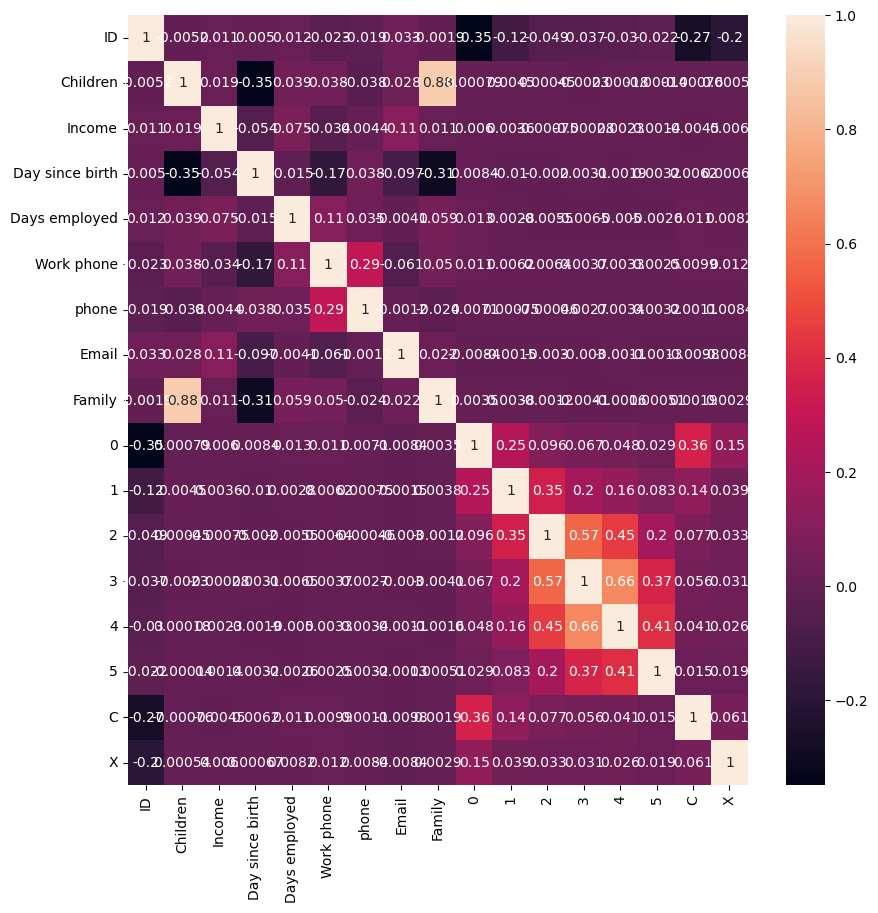

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
sns.heatmap(merged_df.select_dtypes(include =['float64', 'int64']).drop(['Email').corr(), annot = True)